# Imports

In [1]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

/home/sriram/Projects/venvs/CLIP/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Try model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
image = preprocess(Image.open("images/octopus.jpeg")).unsqueeze(0).to(device)
text = clip.tokenize(["a starfish", "some fish", "an octopus"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

In [4]:
print(text_features.shape)
print(image_features.shape)

torch.Size([3, 512])
torch.Size([1, 512])


In [5]:
print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[2.2478436e-01 6.1207225e-05 7.7515441e-01]]


In [6]:
clip.available_models()

['RN50', 'ViT-B/32']

# Show processed image ready to be input 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])
tensor(-1.6463)
tensor(2.1459)


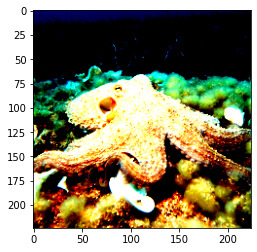

In [7]:
n_px = image.size(-1)

print(image.shape)
print(torch.min(image))
print(torch.max(image))
plt.imshow(image.cpu().squeeze(0).permute(1, 2, 0))

# Show original image

torch.Size([3, 974, 1280])
tensor(0.)
tensor(1.)


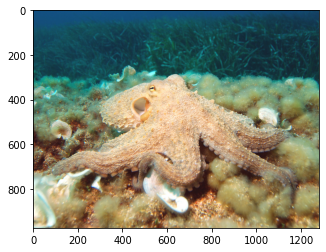

In [8]:
totens = ToTensor()

img_orig = totens(Image.open("images/octopus.jpeg"))
print(img_orig.shape)
print(torch.min(img_orig))
print(torch.max(img_orig))

plt.imshow(img_orig.permute(1, 2, 0))

# Take a chunk out of the image and compare the encodings, then see model output probabilities

(25088,)
(224, 224)


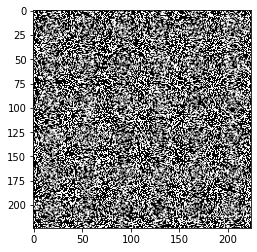

In [9]:
im_dim = n_px*n_px
num_remove = int(0.5*im_dim)

removed_secs = np.random.choice(im_dim, num_remove) #the elements of the image to remove

print(removed_secs.shape)

random_img_mask = np.ones(im_dim)
random_img_mask[removed_secs] = 0
random_img_mask = random_img_mask.reshape(n_px, n_px)

print(random_img_mask.shape)

plt.imshow(random_img_mask, cmap='Greys')

(224, 224)


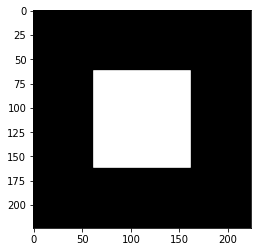

In [10]:
square_len = 100

removed_secs = np.arange((n_px//2)-(square_len//2), (n_px//2)+(square_len//2))
x, y = np.meshgrid(removed_secs, removed_secs)

sq_img_mask = np.ones(im_dim).reshape(n_px, n_px)
sq_img_mask[x, y] = 0

print(sq_img_mask.shape)

plt.imshow(sq_img_mask, cmap='Greys')

In [11]:
#Same as CLIP processing without the normalization yet
transform = Compose([
        Resize(n_px, interpolation=Image.BICUBIC),
        CenterCrop(n_px),
        lambda image: image.convert("RGB"),
        ToTensor()
    ])

#Separate the normalization as after the missing pixels
normalisation = Compose([
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor(0.0392)
tensor(1.)


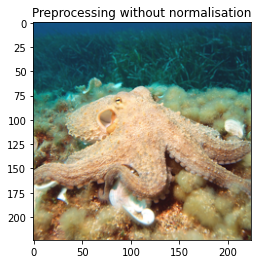

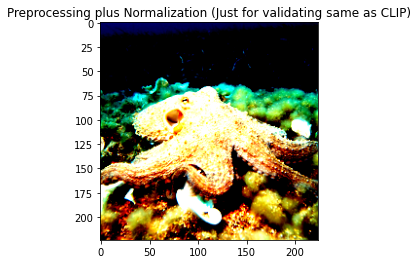

In [12]:
img_orig = transform(Image.open("images/octopus.jpeg"))
print(img_orig.shape)
print(torch.min(img_orig))
print(torch.max(img_orig))

plt.figure()
plt.title("Preprocessing without normalisation")
plt.imshow(img_orig.permute(1, 2, 0))


plt.figure()
plt.title("Preprocessing plus Normalization (Just for validating same as CLIP)")
plt.imshow(normalisation(img_orig).permute(1,2,0))

In [13]:
random_mask = torch.tensor(random_img_mask)
sq_mask = torch.tensor(sq_img_mask)

print(random_mask.shape)
print(sq_mask.shape)

torch.Size([224, 224])
torch.Size([224, 224])


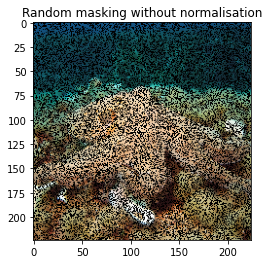

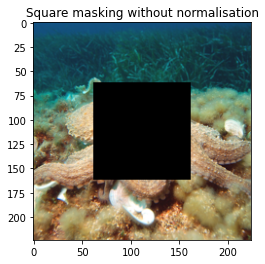

In [14]:
random_masked_img = img_orig*random_mask
sq_masked_img = img_orig*sq_mask

plt.figure()
plt.title("Random masking without normalisation")
plt.imshow(random_masked_img.permute(1, 2, 0))

plt.figure()
plt.title("Square masking without normalisation")
plt.imshow(sq_masked_img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


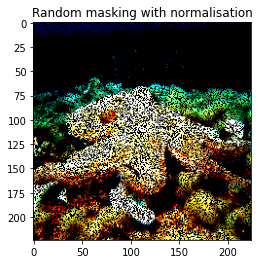

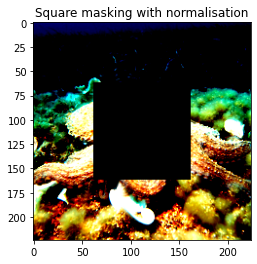

In [15]:
random_masked_norm = normalisation(random_masked_img)
sq_masked_norm = normalisation(sq_masked_img)

plt.figure()
plt.title("Random masking with normalisation")
plt.imshow(random_masked_norm.permute(1, 2, 0))

plt.figure()
plt.title("Square masking with normalisation")
plt.imshow(sq_masked_norm.permute(1, 2, 0))

In [16]:
img_in_rand = random_masked_norm.unsqueeze(0).to(device)
img_in_sq = sq_masked_norm.unsqueeze(0).to(device)

#text = clip.tokenize(["a starfish", "some fish", "an octopus"]).to(device)

with torch.no_grad():
    image_features_1 = model.encode_image(img_in_rand)
    image_features_2 = model.encode_image(img_in_sq)
    text_features = model.encode_text(text)
    
    logits_per_image_1, logits_per_text_1 = model(img_in_rand, text)
    probs_1 = logits_per_image_1.softmax(dim=-1).cpu().numpy()
    
    logits_per_image_2, logits_per_text_2 = model(img_in_sq, text)
    probs_2 = logits_per_image_2.softmax(dim=-1).cpu().numpy()

In [17]:
print("Label probs:", probs)
print("Label probs (random masking):", probs_1) 
print("Label probs (square masking):", probs_2) 

Label probs: [[2.2478436e-01 6.1207225e-05 7.7515441e-01]]
Label probs (random masking): [[0.42300633 0.38451305 0.19248062]]
Label probs (square masking): [[0.60533893 0.00270061 0.39196044]]


In [18]:
cos = torch.nn.CosineSimilarity(dim=1)

rand_diff = cos(image_features, image_features_1).cpu().item()
sq_diff = cos(image_features, image_features_2).cpu().item()

print("Cosine Similarity(E(orig), E(random mask)): ", rand_diff)
print("Cosine Similarity(E(orig), E(square mask)): ", sq_diff)

Cosine Similarity(E(orig), E(random mask)):  0.6707828044891357
Cosine Similarity(E(orig), E(square mask)):  0.8956830501556396


# Create a custom masking transformation

In [19]:
class RandomMask(object):
    """
    Mask an image with a random mask of missing pixels
    """
    
    def __init__(self, percent_missing):
        assert isinstance(percent_missing, float)
        
        self.percent_missing = percent_missing
    
    def __call__(self, image):
        h, w = image.shape[-2:]
        
        removed_secs = np.random.choice(h*w, int(h*w*self.percent_missing))

        mask = torch.ones(h*w)
        mask[removed_secs] = 0
        
        return image*mask.view(h, w)

In [20]:
test = Compose([
    RandomMask(0.1)
])

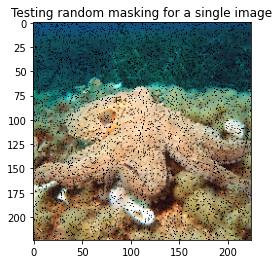

In [21]:
plt.figure()
plt.title("Testing random masking for a single image")
plt.imshow(test(img_orig).permute(1,2,0))

In [22]:
class SquareMask(object):
    """
    Mask an image with a square mask of missing pixels
    
    Args:
        length: side length of the square masked area
        offset: "center" - center the square in the image
                "random" - perform a random vertical and horizontal offset of the square
    """
    
    def __init__(self, length, offset="center"):
        viable_offsets = ["center", "random"]
        
        assert isinstance(offset, str)
        assert isinstance(length, int)
        
        assert offset in viable_offsets 
        
        self.offset = offset
        self.length = length
    
    def __call__(self, image):
        h, w = image.shape[-2:]
        
        assert (self.length < h and self.length < w)
        
        if self.offset == "random":
            #The random offsets define the center of the square region
            h_offset = np.random.choice(np.arange(self.length//2, h-(self.length//2)+1))
            w_offset = np.random.choice(np.arange(self.length//2, w-(self.length//2)+1))
            
            removed_secs_h = np.arange(h_offset-(self.length//2), h_offset+(self.length//2))
            removed_secs_w = np.arange(w_offset-(self.length//2), w_offset+(self.length//2))
            
            x, y = np.meshgrid(removed_secs_h, removed_secs_w)

            mask = torch.ones(h, w)
            mask[x, y] = 0
            
            return image*mask
        
        elif self.offset == "center":
            #The center offsets here are in the middle of the image
            h_offset = h//2
            w_offset = w//2
            
            removed_secs_h = np.arange(h_offset-(self.length//2), h_offset+(self.length//2))
            removed_secs_w = np.arange(w_offset-(self.length//2), w_offset+(self.length//2))
            
            x, y = np.meshgrid(removed_secs_h, removed_secs_w)

            mask = torch.ones(h, w)
            mask[x, y] = 0
            
            return image*mask

In [23]:
test2 = Compose([
    SquareMask(50, "random")
])

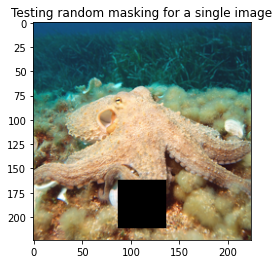

In [24]:
plt.figure()
plt.title("Testing random masking for a single image")
plt.imshow(test2(img_orig).permute(1,2,0))